In [1]:
import json
import os
from time import time
# import re
import pandas as pd
import numpy as np
from collections import Counter
import functools
# from nltk import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
# from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape, Embedding, GlobalMaxPooling1D, Conv1D
from keras.optimizers import SGD 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import warnings


Using TensorFlow backend.


## Preprocessing

In [2]:
random_seed = 7

# Currently removing warnings to make the final notebook more attractive 
# If editing, comment this code out. 
warnings.filterwarnings('ignore')

In [3]:
# takes path, returns list with of albums in json format
# each json entry is a song with lyrics and other metadata
def json_extract(path):
    data_list=[]
    for file in os.listdir(path): 
        if file[-5:] == '.json':
            with open(path+file, 'r') as f: 
                data = json.load(f)
                data_list.append(data)
    return data_list

In [4]:
path = 'data/drake/'
drake=json_extract(path)
path='data/quentin_miller/'
quentin=json_extract(path)

In [5]:
# remove obvious identifiers and stem words
stops={'drizzy', 'drake', 'quentin', 'miller', 'ovo', 'champagne', 'papi','toronto', 'atlanta', '6'}
analyze = CV().build_analyzer()
ps = PorterStemmer()

def stop_removal(lyrics : str): 
    toks=analyze(lyrics)
    return ' '.join([ps.stem(word) for word in toks if not ps.stem(word) in stops])

In [6]:
# resplit the data into train and test 
np.random.seed(random_seed)
X_train = []
train_titles=[]
iyrtitl_lyrics= []
iyrtitl_titles= []
X_test=[]
test_titles=[]
#count number of drake songs in train, test set
d_train_cnt=0
d_test_cnt=0
for album in drake: 
    for song in album: 
        # keep track of "If you're..." to put in test set (iytitl is subject to ambiguous authorship)
        if song["album"]=="If You’re Reading This It’s Too Late ":
            iyrtitl_titles.append(song['title'])
            iyrtitl_lyrics.append(stop_removal(song['lyrics']))
        # oversample from Drake to balance training sample further. 
        elif np.random.random(1) < .15:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics']))   
            d_test_cnt+=1
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))
            d_train_cnt+=1

for album in quentin: 
    for song in album: 
        if np.random.random(1) < .1:
            test_titles.append(song['title'])
            X_test.append(stop_removal(song['lyrics']))   
        else: 
            train_titles.append(song['title'])
            X_train.append(stop_removal(song['lyrics']))

# label drake as 0 and Quentin Miller as 1 in y column. 
y_train=np.zeros(len(X_train))    
y_train[d_train_cnt:]=1
y_test=np.zeros(len(X_test))
y_test[d_test_cnt:]=1

In [7]:
# keep track of validation accuracy of all models (NOT held out test set)
score_dict = {}
#track the cross-validated best estimator. 
model_dict = {}

In [8]:
# baseline preprocessing values to cv on. 
# commented out parameters performed better across the board or didn't provide much improvement so they have been moved to preprocessing or the default transformer
pipe_base = [ ('vect', CV(max_df=.5, ngram_range= (1, 2))), ('tfidf', TfidfTransformer())]
param_base = {   
#     'vect__max_df': (.4, .5), 
    'vect__min_df': (0.002, 0.005, 0.007), 
#     'vect__ngram_range' : (1, 2), (1,3)),
#     'vect__analyzer' : ('word', stemming),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'), 
}

In [9]:
# takes a pipeline, hyperparameters, and a number of folds. 
# prints information about the grid search and returns the GridSearchCV object with the best model
def grid_search(pipeline, param, k=8):
    model = RandomizedSearchCV(pipeline, param, random_state=random_seed, 
                              cv=k, n_iter=8, verbose =0)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:", param)
    start = time()
    model.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - start))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    for param_name in sorted(param.keys()):
        print("\t%s: %r" % (param_name, model.best_params_[param_name]))
    return model

In [10]:
# adds results from gridsearch to global variables model_dict and score_dict 
# key should be a three letter abbreviation for the model's name. 
def track_model (key, pipeline, param, k=8):
    global model_dict
    global score_dict
    grid = grid_search(pipeline, param, k)
    model_dict[key] = grid.best_estimator_
    score_dict[key] = grid.best_score_

## Logistic Regression

In [11]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', LogisticRegression(class_weight='balanced', 
                               random_state=random_seed, 
                               penalty='elasticnet', 
                               solver='saga'))])
params= param_base.copy()
params['clf__l1_ratio'] = (0, 0.1, 0.5, 0.9)
params['clf__C'] = (0.1, 1., 10, 100, 1000)

In [12]:
track_model('log', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__l1_ratio': (0, 0.1, 0.5, 0.9), 'clf__C': (0.1, 1.0, 10, 100, 1000)}
done in 32.410s
Best score: 0.857
Best parameters set:
	clf__C: 1000
	clf__l1_ratio: 0.1
	tfidf__norm: 'l1'
	tfidf__use_idf: True
	vect__min_df: 0.005


## Stochastic Gradient Decent

In [13]:
# use modified_huber to ensure we get probability estimates
pipeline = Pipeline(steps=pipe_base + [('clf', SGDClassifier(class_weight='balanced', 
                          random_state=random_seed,  loss= 'modified_huber'))])
params= param_base.copy()
params['clf__alpha'] = (0.0001, 0.001, 0.01)
params['clf__l1_ratio'] =(0, 0.5, 0.75, 1)
params['clf__tol'] = (0.0001, 0.001)
# params['clf__loss'] =  (‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’)

In [14]:
track_model('sgd', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__alpha': (0.0001, 0.001, 0.01), 'clf__l1_ratio': (0, 0.5, 0.75, 1), 'clf__tol': (0.0001, 0.001)}
done in 17.571s
Best score: 0.877
Best parameters set:
	clf__alpha: 0.0001
	clf__l1_ratio: 1
	clf__tol: 0.001
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.002


## Support Vector Classification

In [15]:
# Use linear kernel to ensure probability estimates 
# (however we can uncomment and delete to CV different kernels)
pipeline = Pipeline(steps=
    pipe_base + [('clf', SVC(kernel='linear', random_state=random_seed, 
                             class_weight='balanced', probability=True))])

params = param_base.copy()
# params['clf__kernel'] = ('linear', 'poly', 'rbf')
params['clf__C'] = (0.1, 0.5, 0.75, 0.9)

In [16]:
track_model('svc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__C': (0.1, 0.5, 0.75, 0.9)}
done in 61.929s
Best score: 0.851
Best parameters set:
	clf__C: 0.5
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__min_df: 0.007


## Random forest 

In [17]:
pipeline = Pipeline(steps=
    pipe_base + [('clf', RandomForestClassifier(class_weight='balanced'))])

params= param_base.copy()
params['clf__n_estimators'] = (100, 150, 200) 
# params['clf__max_depth'] = (30, 50, 100)
params['clf__max_features'] = (50, 75, 100)
# params['clf__min_samples_split'] = (2, 4, 8)

# params['clf__max_leaf_nodes'] = (5, 25, 50)

In [18]:
track_model('rfc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__n_estimators': (100, 150, 200), 'clf__max_features': (50, 75, 100)}
done in 35.087s
Best score: 0.822
Best parameters set:
	clf__max_features: 75
	clf__n_estimators: 200
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__min_df: 0.007


## AdaBoost

In [19]:
pipeline = Pipeline(steps=
    pipe_base+[('clf', AdaBoostClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__base_estimator'] = (DTC(max_depth=1), DTC(max_depth=2), DTC(max_depth=4))
params['clf__n_estimators'] = (100, 120, 140)
params['clf__learning_rate'] = (1, 2)

In [20]:
track_model('ada', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__base_estimator': (DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4)), 'clf__n_estimators': (100, 120, 140), 'clf__learning_rate': (1, 2)}
done in 99.838s
Best score: 0.839
Best parameters set:
	clf__base_estimator: DecisionTreeClassifier(max_depth=1)
	clf__learning_rate: 1
	clf__n_estimators: 120
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__min_df: 0.005


## Gradient Boosting

In [21]:
pipeline = Pipeline(steps=
                    pipe_base + [('clf', GradientBoostingClassifier(random_state=random_seed))])

params = param_base.copy()
params['clf__learning_rate'] =(0.5, 0.1)
params['clf__n_estimators'] = (50, 75, 100)
# params['clf__min_samples_leaf']= (1,2,5)
params['clf__max_depth'] = (2, 5)
# params['clf__min_impurity_decrease'] =  (0, 0.01, 0.05)
params['clf__tol'] =  (0.0001, 0.001)

In [22]:
track_model('gbc', pipeline, params)

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: {'vect__min_df': (0.002, 0.005, 0.007), 'tfidf__use_idf': (True, False), 'tfidf__norm': ('l1', 'l2'), 'clf__learning_rate': (0.5, 0.1), 'clf__n_estimators': (50, 75, 100), 'clf__max_depth': (2, 5), 'clf__tol': (0.0001, 0.001)}
done in 230.772s
Best score: 0.828
Best parameters set:
	clf__learning_rate: 0.1
	clf__max_depth: 5
	clf__n_estimators: 75
	clf__tol: 0.001
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__min_df: 0.002


## Nueral Network

In [23]:
# fit on training data
maxlen = 700
num_words=3000
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)+1

In [24]:
# transform corpus into word embeddings
Xcnn_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
Xcnn_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)
Xcnn_iyrtest = pad_sequences(tokenizer.texts_to_sequences(iyrtitl_lyrics), maxlen=maxlen)


In [25]:
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.0005, 
                                              patience=10, verbose=0, mode='auto')

In [26]:
def random_grid_search(build_fn, params, k, epochs, batch_size, n_iter): 
    model = KerasClassifier(build_fn=build_fn, verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=params, cv=k, verbose=1, n_iter=n_iter)
    print("Performing grid search...")
    print("parameters:", params)
    start = time()
    result = grid.fit(Xcnn_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[earlyStopping])
    print("done in %0.3fs" % (time() - start))
    print("Best score: %0.3f" % result.best_score_)
    print("Best parameters set:")
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, result.best_params_[param_name]))
    return result
    
    
#     test_accuracy= grid.score(X_test, y_test)
#     print("validation accuracy of best model: {}\n".format(test_accuracy))
#     return result

In [27]:
# node layers currently only uses the first 2 elements as number of nodes in dense layers.
def build_fn(node_layer, num_filters, kernel_size, vocab_size, embedding_dim, maxlen): 
    model = Sequential([
        Embedding(input_dim = vocab_size, 
              output_dim = embedding_dim,
              input_length=maxlen),
        Conv1D(num_filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(), 
        Dense(node_layer, activation='relu'),
        Dense(node_layer, activation='relu'),
        Dense(1, activation='sigmoid')])
    model.compile(optimizer='sgd', loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
embedding_dim = 50
params= {
    'node_layer' : [25,10],
    'num_filters' : [32, 64, 128],
    'kernel_size':[3,5,7],
    'vocab_size' : [vocab_size],
    'embedding_dim' : [embedding_dim],
    'maxlen' :[maxlen],
}

In [29]:
epochs = 50
batch_size=32
cnn_model=random_grid_search(build_fn, params, 8, epochs, batch_size, 5)

Performing grid search...
parameters: {'node_layer': [25, 10], 'num_filters': [32, 64, 128], 'kernel_size': [3, 5, 7], 'vocab_size': [5590], 'embedding_dim': [50], 'maxlen': [700]}
Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 14.7min finished


done in 900.733s
Best score: 0.637
Best parameters set:
	embedding_dim: 50
	kernel_size: 3
	maxlen: 700
	node_layer: 10
	num_filters: 64
	vocab_size: 5590


In [30]:
score_dict['cnn']=cnn_model.best_score_

## Ensemble

In [31]:
# Produces the average of prediction probabilities all the models (unweighted)
# We've removed the machine learning model from this method because it doesn't improve over the baseline accuracy. 
def ensemble_proba(corpus): 
    arr=np.zeros((len(corpus), 2*(len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        probs = model_dict[key]['clf'].predict_proba(corp)
        arr[:, 2*ind]=probs[:, 0]
        arr[:, 2*ind+1]=-probs[:, 1]
#     corp=pad_sequences(tokenizer.texts_to_sequences(corpus), maxlen=maxlen)
#     probs =cnn_model.best_estimator_.predict_proba(corp)
#     arr[:,-2]=probs[:,0]
#     arr[:,-1]=-probs[:,1]
    preds = np.sum(arr, axis=1)
    return(preds/(2*len(model_dict))+.5)


In [33]:
# predicts using a majority wins approach. 
# note: ties currently are handled sloppily
def ensemble_pred(corpus): 
    arr=np.zeros((len(corpus), (len(model_dict))))
    preds = np.zeros(len(corpus))
    for ind, key in enumerate(model_dict): 
        corp = model_dict[key]['vect'].transform(corpus)
        corp = model_dict[key]['tfidf'].transform(corp)
        arr[:, ind] = model_dict[key]['clf'].predict(corp)
#         arr[:, 2*ind]=probs[:, 0]
#         arr[:, 2*ind+1]=-probs[:, 1]
#     corp=pad_sequences(tokenizer.texts_to_sequences(corpus), maxlen=maxlen)
#     arr[:,-1] =cnn_model.best_estimator_.predict(corp)[:, 0]
    preds=np.sum(arr, axis=1)
    f = lambda x: 1 if (x > 3) else 0
    return np.array([f(pred) for pred in preds])

## Results

### Model Comparisons

In [34]:
df_models=pd.DataFrame(index=score_dict.keys(), columns = ['train', 'validation', 'test'])
df_models['validation'] = score_dict.values()
training=np.zeros(len(score_dict))
testing=np.zeros(len(score_dict))
for ind, key in enumerate(model_dict): 
    X_trans = model_dict[key]['vect'].transform(X_train)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    print(key, " train: {:.2f}".format(accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))))
    training[ind]=accuracy_score(y_train, model_dict[key]['clf'].predict(X_trans))
    X_trans = model_dict[key]['vect'].transform(X_test)
    X_trans = model_dict[key]['tfidf'].transform(X_trans)
    testing[ind]=accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))
# print indexes and values just to be safe
    print(key, " test: {:.2f}".format(accuracy_score(y_test, model_dict[key]['clf'].predict(X_trans))))

X_trans=pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
training[-1]= accuracy_score(y_train, cnn_model.best_estimator_.predict(X_trans)) 
print("cnn train: {:.2f}".format(accuracy_score(y_train, cnn_model.best_estimator_.predict(X_trans)))) 
X_trans=pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)
testing[-1]= accuracy_score(y_test, cnn_model.best_estimator_.predict(X_trans)) 
print("cnn test: {:.2f}".format(accuracy_score(y_test, cnn_model.best_estimator_.predict(X_trans)))) 
df_models['train']=training
df_models['test']=testing
df2=pd.DataFrame(np.array([accuracy_score(y_train,ensemble_pred(X_train)), 
                  float('Nan'), 
                  accuracy_score(y_test,ensemble_pred(X_test))]).reshape(1,3), 
                     columns=['train', 'validation', 'test'], index=['ens'])
df_models=df_models.append(df2)


log  train: 0.99
log  test: 0.91
sgd  train: 1.00
sgd  test: 0.96
svc  train: 0.95
svc  test: 0.87
rfc  train: 1.00
rfc  test: 0.89
ada  train: 1.00
ada  test: 0.87
gbc  train: 1.00
gbc  test: 0.87
cnn train: 0.64
cnn test: 0.73


In [35]:
df_models

,train,validation,test
log,0.994152,0.856866,0.909091
sgd,1.000000,0.877284,0.963636
svc,0.953216,0.851121,0.872727
rfc,1.000000,0.821913,0.890909
ada,1.000000,0.839355,0.872727
gbc,1.000000,0.827589,0.872727
cnn,0.640351,0.636628,0.727273
ens,1.000000,NaN,0.963636


In [36]:
best_key=df_models.idxmax(axis=0)['validation']
print("The best model is: ", best_key)

The best model is:  sgd


### Probability Predictions for *If You're Reading this it's Too Late* songs 

In [37]:
# track the test set predictions for held out "If You're Reading This its Too Late" 
df_iyrtitl=pd.DataFrame(np.zeros(len(iyrtitl_titles)), index=iyrtitl_titles, columns=["credits"])
credits = ['10 Bands', "Legend", "Know Yourself", "Used To"]
for name in credits:
    df_iyrtitl.loc[name]=1

In [38]:
# predictions for iyrtitl
for key in model_dict:
    test = model_dict[key]['vect'].transform(iyrtitl_lyrics)
    test = model_dict[key]['tfidf'].transform(test)
    df_iyrtitl[key+'_drake']= model_dict[key]['clf'].predict_proba(test)[:,0]
    df_iyrtitl[key+'_quen']= 1-df_iyrtitl[key+'_drake']
df_iyrtitl['cnn_drake']=cnn_model.best_estimator_.predict_proba(Xcnn_iyrtest)[:,0]
df_iyrtitl['cnn_quen']=1-df_iyrtitl['cnn_drake']
df_iyrtitl['ens_drake']=ensemble_proba(iyrtitl_lyrics)
df_iyrtitl['ens_quen']=1-df_iyrtitl['ens_drake']
df_iyrtitl

,credits,log_drake,log_quen,sgd_drake,sgd_quen,svc_drake,svc_quen,rfc_drake,rfc_quen,ada_drake,ada_quen,gbc_drake,gbc_quen,cnn_drake,cnn_quen,ens_drake,ens_quen
Legend,1.0,0.569839,0.430161,1.000000,0.000000,0.824258,0.175742,0.615,0.385,0.527107,0.472893,0.875534,0.124466,0.618262,0.381738,0.735290,0.264710
Energy,0.0,0.550174,0.449826,1.000000,0.000000,0.868980,0.131020,0.700,0.300,0.549251,0.450749,0.949803,0.050197,0.618083,0.381917,0.769701,0.230299
10 Bands,1.0,0.471147,0.528853,0.000000,1.000000,0.147887,0.852113,0.530,0.470,0.454938,0.545062,0.182619,0.817381,0.618124,0.381876,0.297765,0.702235
Know Yourself,1.0,0.546283,0.453717,0.809075,0.190925,0.839718,0.160282,0.550,0.450,0.524542,0.475458,0.586055,0.413945,0.618013,0.381987,0.642612,0.357388
No Tellin’,0.0,0.468989,0.531011,0.485460,0.514540,0.202836,0.797164,0.630,0.370,0.531627,0.468373,0.476324,0.523676,0.619646,0.380354,0.465873,0.534127
Madonna,0.0,0.572466,0.427534,0.275798,0.724202,0.945920,0.054080,0.685,0.315,0.504395,0.495605,0.918743,0.081257,0.619461,0.380539,0.650387,0.349613
6 God,0.0,0.577260,0.422740,0.801165,0.198835,0.921508,0.078492,0.555,0.445,0.605141,0.394859,0.224102,0.775898,0.618113,0.381887,0.614029,0.385971
Star67,0.0,0.539407,0.460593,0.533049,0.466951,0.761834,0.238166,0.610,0.390,0.453889,0.546111,0.831328,0.168672,0.618750,0.381250,0.621585,0.378415
Preach,0.0,0.590937,0.409063,0.966488,0.033512,0.970435,0.029565,0.615,0.385,0.508455,0.491545,0.193880,0.806120,0.618017,0.381983,0.640866,0.359134
Wednesday Night Interlude,0.0,0.590223,0.409777,0.954190,0.045810,0.490013,0.509987,1.000,0.000,0.533212,0.466788,0.961439,0.038561,0.617288,0.382712,0.754846,0.245154


In [39]:
# Best model's prediction
df_iyrtitl[[best_key+'_drake', best_key+ "_quen"]]

,sgd_drake,sgd_quen
Legend,1.000000,0.000000
Energy,1.000000,0.000000
10 Bands,0.000000,1.000000
Know Yourself,0.809075,0.190925
No Tellin’,0.485460,0.514540
Madonna,0.275798,0.724202
6 God,0.801165,0.198835
Star67,0.533049,0.466951
Preach,0.966488,0.033512
Wednesday Night Interlude,0.954190,0.045810


In [40]:
def predict_proba(key, data): 
    data=model_dict[best_key]['vect'].transform(data)
    data=model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict_proba(data)

In [41]:
def predict(key, data):
    data=model_dict[best_key]['vect'].transform(data)
    data=model_dict[best_key]['tfidf'].transform(data)
    return model_dict[best_key]['clf'].predict(data)

In [42]:
# test predictions for best model
preds= predict_proba(best_key, X_test)
test_predictions_df=pd.DataFrame(preds, index=test_titles, columns=['drake_prob', 'quen_prob'])
test_predictions_df['prediction']=predict(best_key, X_test)
test_predictions_df['true']=y_test
test_predictions_df

,drake_prob,quen_prob,prediction,true
Dreams Money Can Buy,0.551787,0.448213,0.0,0.0
5 AM in Toronto,1.000000,0.000000,0.0,0.0
Heat of the Moment,1.000000,0.000000,0.0,0.0
Zodiac Sign,1.000000,0.000000,0.0,0.0
Not Around,0.588594,0.411406,0.0,0.0
Desires,1.000000,0.000000,0.0,0.0
Time Flies,1.000000,0.000000,0.0,0.0
Demons,0.954190,0.045810,0.0,0.0
Madiba Riddim,1.000000,0.000000,0.0,0.0
Portland,1.000000,0.000000,0.0,0.0


### Feature Importances

In [43]:
# this section works assuming a linear model is the best predictor. See commented out code below for code 
# which aggregates feature importance from ensemble and linear predictors. 
# The results of the most important predictors were relatively stable across runs and models.

In [45]:
# track words that are best "drake" predictors, "miller" predictors
drake_tokens=[]
quentin_tokens=[]
cdf= pd.DataFrame(model_dict[best_key]['clf'].coef_.T, 
                model_dict[best_key]['vect'].get_feature_names(), 
                columns=['Coefficients']).sort_values(['Coefficients'])

In [46]:
# Best Drake predictors 
cdf[:10]

,Coefficients
re,-9.204515
girl,-7.553017
you re,-7.281983
caus,-6.239747
love,-5.868416
night,-5.007178
are,-4.801884
oh oh,-4.521083
err,-4.501961
oh,-4.451060


In [47]:
# Best Quentin Miller predictors
cdf[-10:]

,Coefficients
let,6.662021
live,6.692324
wait wait,6.694916
nike,6.987055
wa,7.085856
whoa,7.157851
yuh,7.458169
wait,8.116200
came,8.730083
yeah yeah,12.317516


In [48]:
# # track words that are best "drake" predictors, "miller" predictors, and generally influenctial
# drake_tokens=[]
# quentin_tokens=[]
# total_tokens=[]

# # keys for models that have meaningful coefficients
# keys1 = ['log', 'sgd', 'svc']


# for key in keys1: 
#     cdf = pd.DataFrame(model_dict[key]['clf'].coef_.T, 
#                    model_dict[key]['vect'].get_feature_names(), 
#                    columns=['Coefficients']).sort_values(['Coefficients'])
#     drake_tokens.append(cdf.index.tolist()[:10])
#     total_tokens.append(cdf.index.tolist()[:10])
#     total_tokens.append(cdf.index.tolist()[-10:])
#     quentin_tokens.append(cdf.index.tolist()[-10:])

# keys for models with features that have magnitude but no direction
# keys2 = ['rfc', 'ada', 'gbc']
# for key in keys2: 
#     cdf = pd.DataFrame(model_dict[key]['clf'].feature_importances_.T, 
#                    model_dict[key]['vect'].get_feature_names(), 
#                    columns=['Coefficients']).sort_values(['Coefficients'])
#     total_tokens.append(cdf[-20:].index.tolist())
# # concatenate list of list of words into just list of words 
# l_drake=functools.reduce(lambda x, y : x+y, drake_tokens, [])
# l_quen=functools.reduce(lambda x, y : x+y, quentin_tokens, [])
# l_tot=functools.reduce(lambda x, y : x+y, total_tokens, [])    

In [49]:
# plt.figure(figsize=(20,10))
# cnt=Counter(l_tot)
# cnt10 = t.most_common(10)
# plt.bar([a for a,b in cnt10], [b/len(model_dict) for a,b in cnt10])plt.xticks(rotation='vertical')
# plt.ylabel("Percentage of models where word was influential")
# plt.title("Ten Most Common Influential Predictors")
# plt.show;

In [50]:
# print("Top drake predictors")
# [print(x) for x in Counter(l_drake)]
# print("\nTop Quentin Miller predictors")
# [print(x) for x in Counter(l_quen)];

### Comparison of Drake Albums

In [51]:
# comment in if memory is low and you need to space for the reorganized corpus
# del X_train
# del y_train 

#reorganize corpus by album for further exploration of which songs are most "Drake-like"
album_dict={}
song_titles_dict={}
for album in drake: 
    if len(album) < 10:
        continue
    album_dict[album[0]['album'].strip()]= [stop_removal(song['lyrics']) for song in album]
    song_titles_dict[album[0]['album'].strip()] = [song['title'] for song in album]

In [52]:
album_mean={}
for album_key in album_dict:
    X_train= model_dict[best_key]['tfidf'].transform(model_dict[best_key]['vect'].transform(album_dict[album_key]))
    preds=model_dict[best_key]['clf'].predict_proba(X_train)[:,0]
    album_mean[album_key]=np.mean(preds)

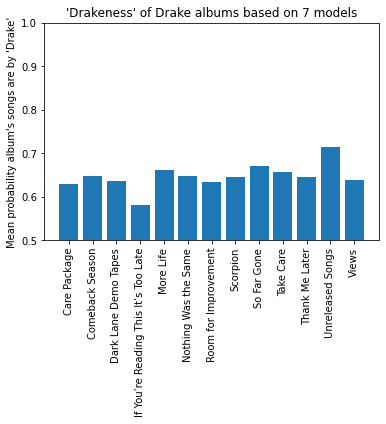

In [53]:
plt.bar(album_mean.keys(), album_mean.values())
plt.xticks(range(len(album_mean)), album_mean.keys(), rotation='vertical')
plt.ylim(0.5,1)
plt.ylabel("Mean probability album's songs are by 'Drake'")
plt.title("'Drakeness' of Drake albums based on 7 models")
plt.show()